In [20]:
import glob
import os
import gc
import pickle
import colorcet as cc
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mne
import mne_bids

from wordfreq import zipf_frequency
from tqdm import tqdm

In [10]:
REPORTS = "../reports/"
REPORTS_DISK = "/media/nathan/Seagate Basic/meg-encoding/reports/"

In [132]:
cmap = cc.glasbey_hv
names = [
#     "BERT20", 
#     "BERT5",
#     #"BERT4",
#     "BERT1",
#     "BERT5-R",
#     "BERT20-R", 
#     "BERT5-lag1",
#     "BERT5-lag2",
#     "BERT5-lag3",
#     "BERT5-lag1-R",
#     "BERT5-lag2-R",
#     "BERT5-lag3-R",
#     "BERT5-res1",
#     "BERT5-res2",
#     "BERT5-res3",
#     "BERT5-res1-R",
#     "BERT5-res2-R",
#     "BERT5-res3-R",
    "GloVe", 
    "CM",
    "POS",
    "DEP",
]

colors = {n: cmap[i] for i, n in enumerate(names)}
colors["MEG"] = "gray"
# colors = {
#     "MEG": "gray", 
#     "BERT20": "#B03A2E", 
#     "BERT20-R": "#21618C",
#     "BERT5": "#F1948A",
#     "BERT4": "#229954",
#     "BERT5-R": "#85C1E9",
#     "BERT-res": "#AF7AC5", 
#     "GloVe": "#48C9B0",
#     "CM": "#873600",
#     "POS": "#F39C12", 
#     "DEP": "#F4D03F",
# }

In [7]:
with open("../data/meta/info-12-word-100Hz-800ms-simple-rescale.pkl", "rb") as fp:
    info = pickle.load(fp)

In [8]:
nchan = 208
ntime = 81

In [28]:
files = list(glob.glob(REPORTS + f"sub*/bert_s0_predictions/"))

ff = ["/".join((f.split("/")[-2:])) for f in files]
for fp in list(glob.glob(REPORTS_DISK + f"sub*/bert_s0_predictions/")):

    if "/".join(fp.split("/")[-2:]) not in ff:
        files.append(fp)

display(sorted(files))

['../reports/sub-1/bert_s0_predictions/',
 '../reports/sub-2/bert_s0_predictions/',
 '../reports/sub-3/bert_s0_predictions/',
 '../reports/sub-4/bert_s0_predictions/',
 '../reports/sub-5/bert_s0_predictions/',
 '../reports/sub-6/bert_s0_predictions/',
 '../reports/sub-7/bert_s0_predictions/',
 '../reports/sub-8/bert_s0_predictions/']

In [29]:
def load_results(exp, kind, info, nchan, ntime, concat=False, reshape=True):
    files = sorted(glob.glob(f"../reports/sub*/{exp}_s0_predictions/"))
    
    if kind in ["corr", "r2s", "sig_group_corrected"]:
        res_fp = sorted(glob.glob(f"../reports/sub*/{exp}_s0_predictions/*{kind}.npy"))
    else:
        res_fp = sorted(glob.glob(f"../reports/sub*/{exp}_s0_predictions/*{kind}*"))
    
    print(f"Loading {exp}, found sub: {len(files)}, found files: {len(res_fp)}")

    preds = dict()
    for fp in tqdm(files):
        sub = fp.split("/")[-3].split("-")[-1]
        
        if kind in ["corr", "r2s", "sig_group_corrected"]:
            res_files = sorted(glob.glob(f"{fp}/*{kind}.npy"))
            try:
                if reshape:
                    preds[sub] = np.load(res_files[0]).reshape(-1, nchan, ntime).squeeze()
                else:
                     preds[sub] = np.load(res_files[0])
            except:
                print(f"Missing: {exp} - {kind}, Sub: {sub} ")
                continue
                
        else:
            res_files = sorted(glob.glob(f"{fp}/*{kind}*"))
            results = []
            for story in range(4):
                if reshape:
                    results.append(np.load(res_files[story]).reshape(-1, nchan, ntime).squeeze())
                else:
                    results.append(np.load(res_files[story]))
            preds[sub] = np.concatenate(results)
        
    if concat:
        preds = np.concatenate(list(preds.values()))
        
    return preds

def load_test(exp, info, nchan, ntime, reshape=True):
    files = sorted(glob.glob(f"../reports/sub*/{exp}_s0_predictions/"))
    
    fp = files[0]

    res_files = sorted(glob.glob(f"{fp}/*test*"))

    y_test = []
    for story in range(4):
        if reshape:
            y_test.append(np.load(res_files[story]).reshape(-1, nchan, ntime).squeeze())
        else:
            y_test.append(np.load(res_files[story]))
    y_test = np.concatenate(y_test)

    return y_test

def as_evoked(*data, concat=False):
    evoked = []
    for datum in data:
        if concat:
            pred_epochs = np.concatenate(list(datum.values()))
            evoked.append(mne.EpochsArray(pred_epochs, info).average())
        else:
            pred_epochs = dict()
            for sub, preds in datum.items():
                pred_epochs[sub] = mne.EpochsArray(preds, info).average()
            evoked.append(pred_epochs)
        
    if len(evoked) > 1:
        return tuple(evoked)
    else:
        return evoked[0]

def rms(x, axis=0):
    return np.sqrt(np.mean(x**2, axis=axis))

## Predictions

In [6]:
bert20 = as_evoked(load_results(
    exp="bert",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False),
concat=True)


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.52it/s]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [7]:
bert20rh = as_evoked(load_results(
    exp="bertseq20rh",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False),
concat=True)

100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [8]:
bert5 = as_evoked(load_results(
    exp="bertseq5",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False),
concat=True)

100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.39it/s]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [137]:
bert4 = as_evoked(load_results(
    exp="bertseq4",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False),
concat=True)

100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.06s/it]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [9]:
bert5rh = as_evoked(load_results(
    exp="bertseq5rh",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False),
concat=True)

100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.37it/s]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [10]:
bert_res = as_evoked(load_results(
    exp="bertseq_residuals",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False),
concat=True)

100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [11]:
bert4 = as_evoked(load_results(
    exp="bertseq4",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False
),
concat=True)

100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [12]:
glove = as_evoked(load_results(
    exp="glove",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False
),
concat=True)

100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Not setting metadata
59927 matching events found
No baseline correction applied
0 projection items activated


In [14]:
cm = as_evoked(load_results(
    exp="cm",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False
),
concat=True)

100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Not setting metadata
59927 matching events found
No baseline correction applied
0 projection items activated


In [19]:
pos = as_evoked(load_results(
    exp="postag",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False
),
concat=True)

100%|█████████████████████████████████████████████| 8/8 [00:09<00:00,  1.16s/it]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [20]:
dep = as_evoked(load_results(
    exp="deptags",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False
),
concat=True)

100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.54it/s]


Not setting metadata
51366 matching events found
No baseline correction applied
0 projection items activated


In [21]:
gt = as_evoked(load_results(
    exp="bert",
    kind="test",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False),
concat=True)

100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


Not setting metadata
68488 matching events found
No baseline correction applied
0 projection items activated


In [138]:
all_preds = dict(
    zip(
        ["MEG", "BERT20", "BERT20-R", "BERT5", "BERT4", "BERT5-R", "BERT-res", "GloVe", "CM", "POS", "DEP"],
        [gt, bert20, bert20rh, bert5, bert4, bert5rh, bert_res, glove, cm, pos, dep]
    )
)

## All RMS

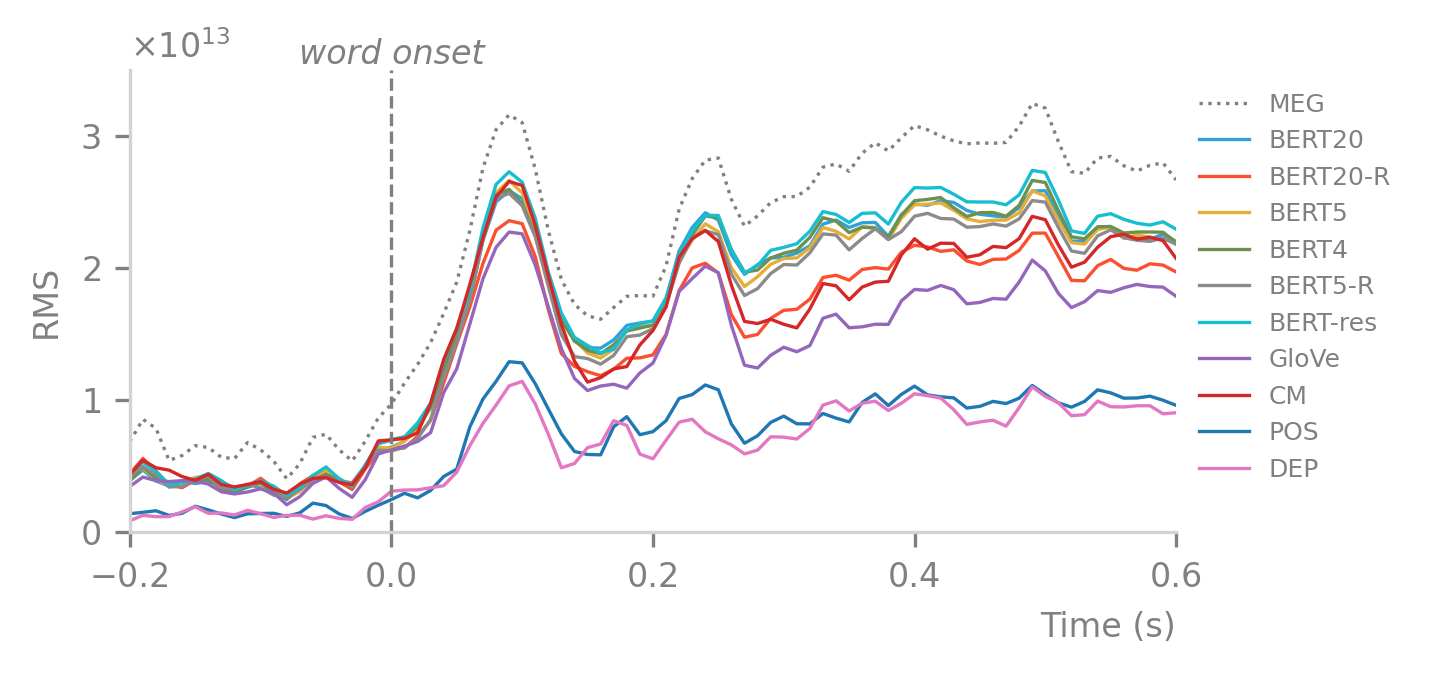

In [140]:
plt.figure(figsize=(4.5, 2))
plt.rcParams.update({'font.size': 11, 'axes.edgecolor': "lightgray"})
plt.tick_params(which="both", colors='gray', labelsize=8)

plt.ylim(0.0, 3.5*1e13)

t = np.linspace(-0.2, 0.6, ntime)

names = ["MEG", "BERT20", "BERT20-R", "BERT5", "BERT4", "BERT5-R", "BERT-res", "GloVe", "CM", "POS", "DEP"]

for name in names:
    x = rms(all_preds[name].get_data() * 1e15) # coef is from MNE
    color = colors[name]
    style = None if name != "MEG" else ":"
    plt.plot(t, x, color=color, linestyle=style, lw=.8, label=name)
    
plt.vlines(0.0, 0.0, 3.5e13, linestyle='--', lw=.8, color="gray")

plt.gca().spines[["right", "top"]].set_visible(False)
plt.gca().legend(fontsize=6, labelcolor="gray", edgecolor="none", bbox_to_anchor=(1, 1))

mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2,2))
plt.gca().yaxis.set_major_formatter(mf)
plt.gca().yaxis.get_offset_text().set_size(8)

plt.xticks(plt.xticks()[0][::2])

plt.ylabel("RMS", size=8, color="gray")
plt.xlabel("Time (s)", size=8, loc="right", color="gray")

plt.text(0.0, 3.55*1e13, "word onset", size=8, color="gray", fontstyle="italic", ha="center")
plt.savefig("../figures/rms-all.pdf")
plt.show()

## BERT RMS

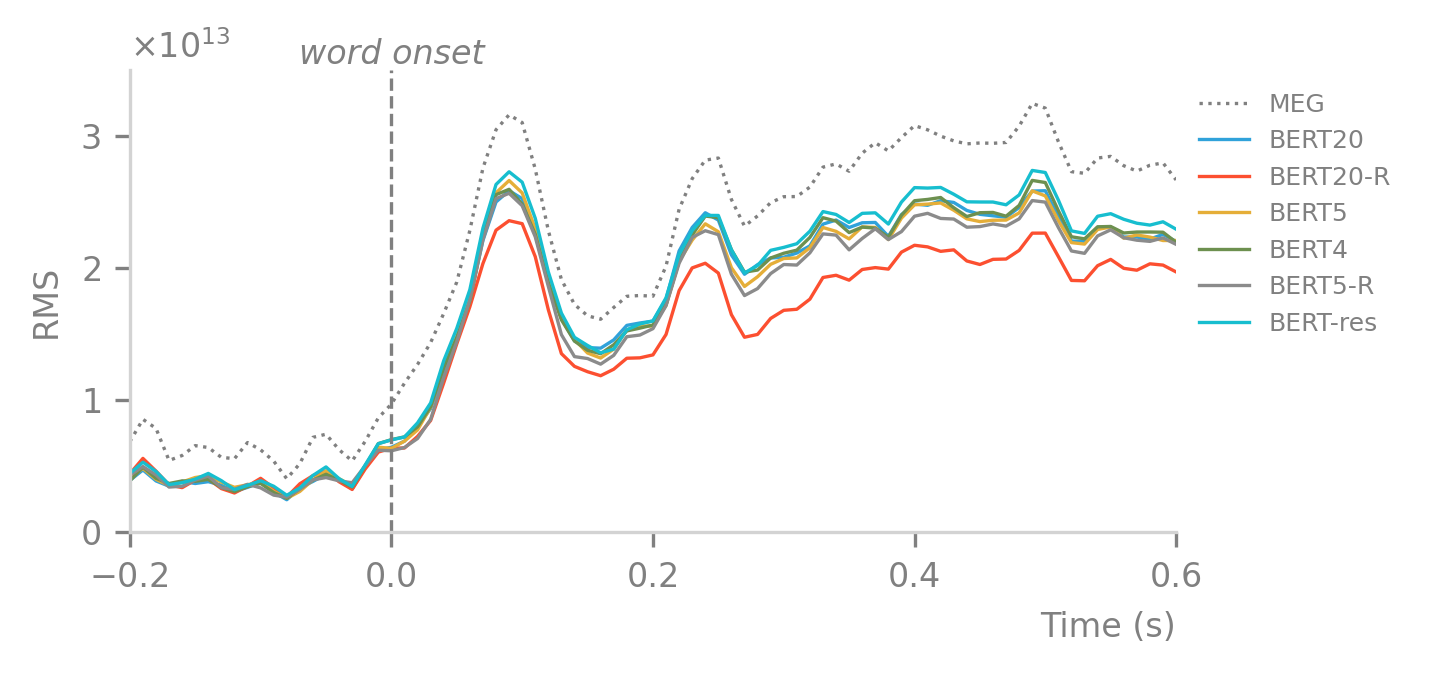

In [143]:
plt.figure(figsize=(4.5, 2))
plt.rcParams.update({'font.size': 11, 'axes.edgecolor': "lightgray"})
plt.tick_params(which="both", colors='gray', labelsize=8)

plt.ylim(0.0, 3.5*1e13)

t = np.linspace(-0.2, 0.6, ntime)

names = ["MEG", "BERT20", "BERT20-R", "BERT5", "BERT4", "BERT5-R", "BERT-res"]

for name in names:
    x = rms(all_preds[name].get_data() * 1e15) # coef is from MNE
    color = colors[name]
    style = None if name != "MEG" else ":"
    plt.plot(t, x, color=color, linestyle=style, lw=.8, label=name)
    
plt.vlines(0.0, 0.0, 3.5e13, linestyle='--', lw=.8, color="gray")

plt.gca().spines[["right", "top"]].set_visible(False)
plt.gca().legend(fontsize=6, labelcolor="gray", edgecolor="none", bbox_to_anchor=(1, 1))

mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2,2))
plt.gca().yaxis.set_major_formatter(mf)
plt.gca().yaxis.get_offset_text().set_size(8)

plt.xticks(plt.xticks()[0][::2])

plt.ylabel("RMS", size=8, color="gray")
plt.xlabel("Time (s)", size=8, loc="right", color="gray")

plt.text(0.0, 3.55*1e13, "word onset", size=8, color="gray", fontstyle="italic", ha="center")
plt.savefig("../figures/rms-bert.pdf")
plt.show()

## $R^2$ plots

In [30]:
bert20_r2 = load_results(
    exp="bert",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert20rh_r2 = load_results(
    exp="bertseq20rh",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_r2 = load_results(
    exp="bertseq5",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_r2 = load_results(
    exp="bertseq5rh",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert1_r2 = load_results(
    exp="bertseq1",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert2_r2 = load_results(
    exp="bertseq2",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert3_r2 = load_results(
    exp="bertseq3",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert4_r2 = load_results(
    exp="bertseq4",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)
#

bert5_lag1_r2 = load_results(
    exp="bertseqlag1_5",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_lag2_r2 = load_results(
    exp="bertseqlag5_2_5",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_lag3_r2 = load_results(
    exp="bertseqlag5_3_5",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

#

bert5rh_lag1_r2 = load_results(
    exp="bertseq5_lag1rh",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_lag2_r2 = load_results(
    exp="bertseq5_lag2rh",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_lag3_r2 = load_results(
    exp="bertseq5_lag3rh",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

##

bert5_res1_r2 = load_results(
    exp="bertseqres_5_1",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_res2_r2 = load_results(
    exp="bertseqres_5_2",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_res3_r2 = load_results(
    exp="bertseqres_5_3",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)


bert5rh_res1_r2 = load_results(
    exp="bertseqres_5_1rh",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_res2_r2 = load_results(
    exp="bertseqres_5_2rh",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_res3_r2 = load_results(
    exp="bertseqres_5_3rh",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False
)

Loading bert, found sub: 8, found files: 8


100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 879.75it/s]


Loading bertseq20rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1537.50it/s]


Loading bertseq5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1638.16it/s]


Loading bertseq5rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1619.97it/s]


Loading bertseq1, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1418.73it/s]


Loading bertseq2, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1673.54it/s]


Loading bertseq3, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1929.19it/s]


Loading bertseq4, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1558.28it/s]


Loading bertseqlag1_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1317.31it/s]


Loading bertseqlag5_2_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1490.51it/s]


Loading bertseqlag5_3_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1528.47it/s]


Loading bertseq5_lag1rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1485.76it/s]


Loading bertseq5_lag2rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1487.21it/s]


Loading bertseq5_lag3rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1567.38it/s]


Loading bertseqres_5_1, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1556.26it/s]


Loading bertseqres_5_2, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1630.91it/s]


Loading bertseqres_5_3, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1583.95it/s]


Loading bertseqres_5_1rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1676.72it/s]


Loading bertseqres_5_2rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1608.94it/s]


Loading bertseqres_5_3rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1657.25it/s]


In [31]:
glove_r2 = load_results(
    exp="glove",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

cm_r2 = load_results(
    exp="cm",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

pos_r2 = load_results(
    exp="postag",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

dep_r2 = load_results(
    exp="deptags",
    kind="r2s",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

Loading glove, found sub: 7, found files: 7


100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 589.06it/s]


Loading cm, found sub: 7, found files: 7


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 1598.61it/s]


Loading postag, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1639.20it/s]


Loading deptags, found sub: 6, found files: 6


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 1445.81it/s]


In [33]:
all_r2s = dict(
    zip(
        [
    "BERT20", 
    "BERT5",
    "BERT4",
    "BERT3",
    "BERT2",
    "BERT1",
    "BERT5-R",
    "BERT20-R", 
    "BERT5-lag1",
    "BERT5-lag2",
    "BERT5-lag3",
    "BERT5-lag1-R",
    "BERT5-lag2-R",
    "BERT5-lag3-R",
    "BERT5-res1",
    "BERT5-res2",
    "BERT5-res3",
    "BERT5-res1-R",
    "BERT5-res2-R",
    "BERT5-res3-R",
    "GloVe", 
    "CM",
    "POS",
    "DEP",
],
        [
            bert20_r2,
            bert5_r2,
            bert4_r2,
            bert3_r2,
            bert2_r2,
            bert1_r2, 
            bert5rh_r2,
            bert20rh_r2, 
            bert5_lag1_r2,
            bert5_lag2_r2,
            bert5_lag3_r2,
            bert5rh_lag1_r2,
            bert5rh_lag2_r2,
            bert5rh_lag3_r2,
            bert5_res1_r2,
            bert5_res2_r2,
            bert5_res3_r2,
            bert5rh_res1_r2,
            bert5rh_res2_r2,
            bert5rh_res3_r2,
            glove_r2,
            cm_r2,
            pos_r2,
            dep_r2,
            ]
    )
)

In [48]:
bert20_corr = load_results(
    exp="bert",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert20rh_corr = load_results(
    exp="bertseq20rh",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_corr = load_results(
    exp="bertseq5",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_corr = load_results(
    exp="bertseq5rh",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert1_corr = load_results(
    exp="bertseq1",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

#

bert5_lag1_corr = load_results(
    exp="bertseqlag1_5",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_lag2_corr = load_results(
    exp="bertseqlag5_2_5",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_lag3_corr = load_results(
    exp="bertseqlag5_3_5",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

#

bert5rh_lag1_corr = load_results(
    exp="bertseq5_lag1rh",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_lag2_corr = load_results(
    exp="bertseq5_lag2rh",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_lag3_corr = load_results(
    exp="bertseq5_lag3rh",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

##

bert5_res1_corr = load_results(
    exp="bertseqres_5_1",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_res2_corr = load_results(
    exp="bertseqres_5_2",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_res3_corr = load_results(
    exp="bertseqres_5_3",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)


bert5rh_res1_corr = load_results(
    exp="bertseqres_5_1rh",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_res2_corr = load_results(
    exp="bertseqres_5_2rh",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_res3_corr = load_results(
    exp="bertseqres_5_3rh",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False
)

Loading bert, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3207.27it/s]


Loading bertseq20rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2510.81it/s]


Loading bertseq5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2940.02it/s]


Loading bertseq5rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2931.03it/s]


Loading bertseq1, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2267.19it/s]


Loading bertseqlag1_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2041.52it/s]


Loading bertseqlag5_2_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2731.11it/s]


Loading bertseqlag5_3_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2132.74it/s]


Loading bertseq5_lag1rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2698.17it/s]


Loading bertseq5_lag2rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2381.60it/s]


Loading bertseq5_lag3rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2517.78it/s]


Loading bertseqres_5_1, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2643.33it/s]


Loading bertseqres_5_2, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2648.55it/s]


Loading bertseqres_5_3, found sub: 7, found files: 7


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2273.86it/s]


Loading bertseqres_5_1rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2716.74it/s]


Loading bertseqres_5_2rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2162.43it/s]


Loading bertseqres_5_3rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2696.22it/s]


In [54]:
glove_corr = load_results(
    exp="glove",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

cm_corr = load_results(
    exp="cm",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

pos_corr = load_results(
    exp="postag",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

dep_corr = load_results(
    exp="deptags",
    kind="corr",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

Loading glove, found sub: 7, found files: 7


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2753.98it/s]


Loading cm, found sub: 7, found files: 7


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2819.56it/s]


Loading postag, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2818.75it/s]


Loading deptags, found sub: 6, found files: 6


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 2627.74it/s]


In [55]:
all_corr = dict(
    zip(
        [
    "BERT20", 
    "BERT5",
    "BERT1",
    "BERT5-R",
    "BERT20-R", 
    "BERT5-lag1",
    "BERT5-lag2",
    "BERT5-lag3",
    "BERT5-lag1-R",
    "BERT5-lag2-R",
    "BERT5-lag3-R",
    "BERT5-res1",
    "BERT5-res2",
    "BERT5-res3",
    "BERT5-res1-R",
    "BERT5-res2-R",
    "BERT5-res3-R",
    "GloVe", 
    "CM",
    "POS",
    "DEP",
],
        [
            bert20_corr,
            bert5_corr, 
            bert1_corr, 
            bert5rh_corr,
            bert20rh_corr, 
            bert5_lag1_corr,
            bert5_lag2_corr,
            bert5_lag3_corr,
            bert5rh_lag1_corr,
            bert5rh_lag2_corr,
            bert5rh_lag3_corr,
            bert5_res1_corr,
            bert5_res2_corr,
            bert5_res3_corr,
            bert5rh_res1_corr,
            bert5rh_res2_corr,
            bert5rh_res3_corr,
            glove_corr,
            cm_corr,
            pos_corr,
            dep_corr,
            ]
    )
)

In [34]:
def average_r2(scores):
    all_scores = list(scores.values())
    evoked = [s.mean(axis=0) for s in all_scores]
    mean, std = np.mean(evoked, axis=0), np.std(evoked, axis=0)
    return mean, std

In [38]:
bert20_sig = load_results(
    exp="bert",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert20rh_sig = load_results(
    exp="bertseq20rh",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_sig = load_results(
    exp="bertseq5",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_sig = load_results(
    exp="bertseq5rh",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert1_sig = load_results(
    exp="bertseq1",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert2_sig = load_results(
    exp="bertseq2",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert3_sig = load_results(
    exp="bertseq3",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert4_sig = load_results(
    exp="bertseq4",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

#

bert5_lag1_sig = load_results(
    exp="bertseqlag1_5",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_lag2_sig = load_results(
    exp="bertseqlag5_2_5",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_lag3_sig = load_results(
    exp="bertseqlag5_3_5",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

#

bert5rh_lag1_sig = load_results(
    exp="bertseq5_lag1rh",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_lag2_sig = load_results(
    exp="bertseq5_lag2rh",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_lag3_sig = load_results(
    exp="bertseq5_lag3rh",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

##

bert5_res1_sig = load_results(
    exp="bertseqres_5_1",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_res2_sig = load_results(
    exp="bertseqres_5_2",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5_res3_sig = load_results(
    exp="bertseqres_5_3",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)


bert5rh_res1_sig = load_results(
    exp="bertseqres_5_1rh",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_res2_sig = load_results(
    exp="bertseqres_5_2rh",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

bert5rh_res3_sig = load_results(
    exp="bertseqres_5_3rh",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False
)

Loading bert, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2645.41it/s]


Loading bertseq20rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2870.84it/s]


Loading bertseq5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2643.95it/s]


Loading bertseq5rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2711.03it/s]


Loading bertseq1, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3041.55it/s]


Loading bertseq2, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2722.25it/s]


Loading bertseq3, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2646.87it/s]


Loading bertseq4, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2709.94it/s]


Loading bertseqlag1_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2459.10it/s]


Loading bertseqlag5_2_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3121.63it/s]


Loading bertseqlag5_3_5, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3769.31it/s]


Loading bertseq5_lag1rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3654.77it/s]


Loading bertseq5_lag2rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3112.08it/s]


Loading bertseq5_lag3rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3330.80it/s]


Loading bertseqres_5_1, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3460.65it/s]


Loading bertseqres_5_2, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2923.62it/s]


Loading bertseqres_5_3, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3414.51it/s]


Loading bertseqres_5_1rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3568.48it/s]


Loading bertseqres_5_2rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3071.06it/s]


Loading bertseqres_5_3rh, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2695.57it/s]


In [39]:
glove_sig = load_results(
    exp="glove",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

cm_sig = load_results(
    exp="cm",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

pos_sig = load_results(
    exp="postag",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

dep_sig = load_results(
    exp="deptags",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

Loading glove, found sub: 7, found files: 7


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2244.83it/s]


Loading cm, found sub: 7, found files: 7


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2021.91it/s]


Loading postag, found sub: 8, found files: 8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2384.48it/s]


Loading deptags, found sub: 6, found files: 6


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 2586.68it/s]


In [41]:
all_sig = dict(
    zip(
        [
    "BERT20", 
    "BERT5",
    "BERT4",
    "BERT3",
    "BERT2",
    "BERT1",
    "BERT5-R",
    "BERT20-R", 
    "BERT5-lag1",
    "BERT5-lag2",
    "BERT5-lag3",
    "BERT5-lag1-R",
    "BERT5-lag2-R",
    "BERT5-lag3-R",
    "BERT5-res1",
    "BERT5-res2",
    "BERT5-res3",
    "BERT5-res1-R",
    "BERT5-res2-R",
    "BERT5-res3-R",
    "GloVe", 
    "CM",
    "POS",
    "DEP",
],
        [
            bert20_sig,
            bert5_sig,
            bert4_sig,
            bert3_sig,
            bert2_sig,
            bert1_sig, 
            bert5rh_sig,
            bert20rh_sig, 
            bert5_lag1_sig,
            bert5_lag2_sig,
            bert5_lag3_sig,
            bert5rh_lag1_sig,
            bert5rh_lag2_sig,
            bert5rh_lag3_sig,
            bert5_res1_sig,
            bert5_res2_sig,
            bert5_res3_sig,
            bert5rh_res1_sig,
            bert5rh_res2_sig,
            bert5rh_res3_sig,
            glove_sig,
            cm_sig,
            pos_sig,
            dep_sig,
            ]
    )
)

In [42]:
import scipy
from scipy.stats import ttest_rel, ttest_1samp
from statsmodels.stats.multitest import fdrcorrection


def r2s_corrected(scores, sig):
    
    all_sub_evoked = []
    for sub in sig.keys():
        
        r2s = scores[sub]
        h0_rejected = sig[sub] <= 0.05
    
        r2s[~h0_rejected] = 0.0  # set all non significative r2 to 0.0
        mean_r2 = np.mean(r2s, axis=0)
        
        all_sub_evoked.append(mean_r2)
        
    return np.array(all_sub_evoked)


def corr_corrected(scores, sig, corr_idx=1):
    
    all_sub_evoked = []
    for sub in scores.keys():
        
        if scores[sub].shape[0] == 2:
            corr = scores[sub][corr_idx, :]
        else:
            corr = scores[sub]
            
        h0_rejected = sig[sub] <= 0.05
        corr[~h0_rejected] = 0.0  # set all non significative pearson r to 0.0

        mean_corr = np.mean(corr, axis=0)
            
        all_sub_evoked.append(mean_corr)
        
    return np.array(all_sub_evoked)

def r2s_stats(scores, sig):
    all_sub_evoked = r2s_corrected(scores, sig)
    return np.mean(all_sub_evoked, axis=0), scipy.stats.sem(all_sub_evoked, axis=0)
    
    
def corr_stats(scores, sig, corr_idx=1):
    all_sub_evoked = corr_corrected(scores, sig, corr_idx=corr_idx)
    return np.mean(all_sub_evoked, axis=0), scipy.stats.sem(all_sub_evoked, axis=0)


def timewise_corrected_ttest_1samp(scores, q=0.05):
    res = ttest_1samp(scores, 0.0, alternative="greater")
    pvalues = res[1]
    corrected_pvalues = fdrcorrection(pvalues, alpha=q)[1]
    return corrected_pvalues

### All $R^2$

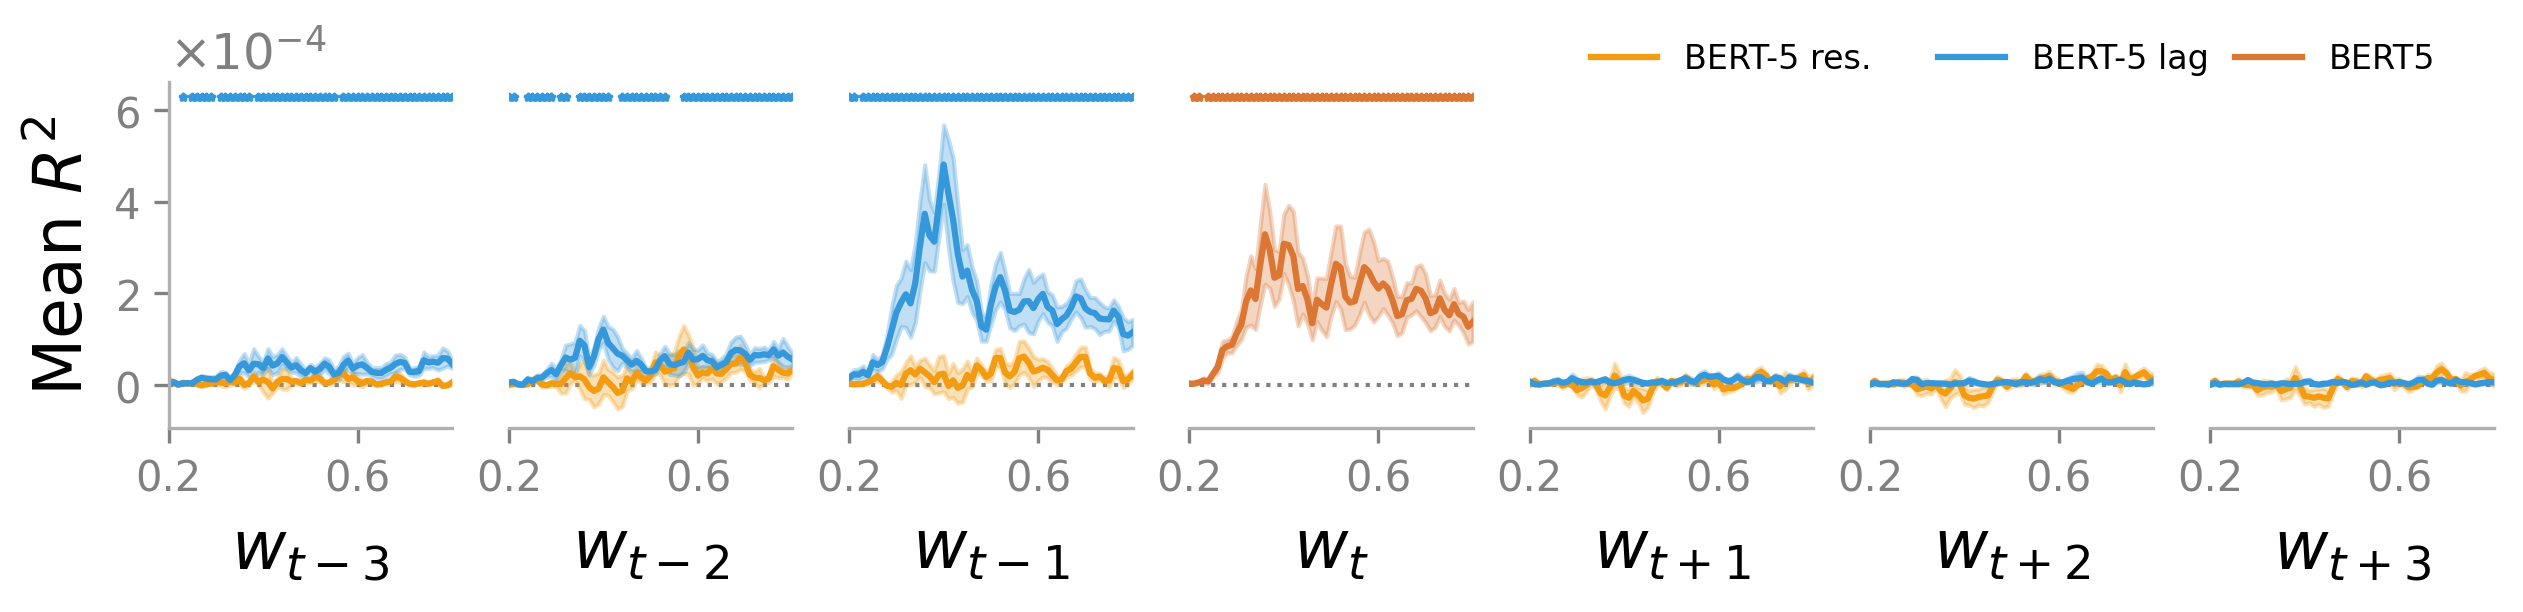

In [80]:
t = np.linspace(0.2, 0.8, ntime-20)

groups = {
    "$w_{t-3}$": ["BERT5-res3", "BERT5-lag3"],
    "$w_{t-2}$": ["BERT5-res2", "BERT5-lag2"],
    "$w_{t-1}$": ["BERT5-res1", "BERT5-lag1"],
    "$w_{t}$": ["BERT5", ],
    "$w_{t+1}$": ["BERT5-res1-R", "BERT5-lag1-R"],
    "$w_{t+2}$": ["BERT5-res2-R", "BERT5-lag2-R"],
    "$w_{t+3}$": ["BERT5-res3-R", "BERT5-lag3-R"],
}

s_colors = {
    "BERT20": "#7D3C98",
    "BERT5": "#DC7633",
    "BERT4": "#3498DB",
    "BERT3": "#AE2727",
    "BERT2": "#DE00F8",
    "BERT1": "#27AE60",
}

# lag_colors = {
#     "BERT5-res3": "#E74C3C",
#     "BERT5-res2": "#27AE60", 
#     "BERT5-res1": "#F1C40F",
#     "BERT5-res3-R": "#E74C3C",
#     "BERT5-res2-R": "#27AE60", 
#     "BERT5-res1-R": "#F1C40F",
#     "BERT5-lag3": "#2980B9",
#     "BERT5-lag2": "#9B59B6",
#     "BERT5-lag1": "#D35400",
#     "BERT5-lag3-R": "#2980B9",
#     "BERT5-lag2-R": "#9B59B6",
#     "BERT5-lag1-R": "#D35400",
# }

fig, axs = plt.subplots(1, len(groups), figsize=(10, 1.5), sharey=True)

sem_scale = 1
max_value = 0
min_value = 0
for i, (lag, features) in enumerate(groups.items()):
    for name in features:
        scores = all_r2s[name]
        pvalues = all_sig[name]
        mean, sem = r2s_stats(scores, pvalues)
        
        if "res" in name:
            color = "#F39C12"
            label = "BERT-5 res."
        elif "lag" in name:
            color = "#3498DB"
            label = "BERT-5 lag"
        else:
            color = s_colors[name]
            label = name
            
        axs[i].plot(t, mean[20:], color=color, lw=1.5, label=label)
        axs[i].fill_between(t, mean[20:]-sem[20:]*sem_scale, mean[20:]+sem[20:]*sem_scale, alpha=0.3, color=color)

        if max(mean+sem*sem_scale) > max_value:
            max_value = max(mean+sem*sem_scale)

        if min(mean-sem*sem_scale) < min_value:
            min_value = min(mean-sem*sem_scale)
            
    axs[i].set_xlabel(lag)
    
    if i == 0:
        axs[i].legend(fontsize=8, edgecolor="none", bbox_to_anchor=(7.3, 1.2), ncols=2)
        axs[i].set_ylabel("Mean $R^2$")
    if i == 3:
        axs[i].legend(fontsize=8, edgecolor="none", bbox_to_anchor=(4.5, 1.2), ncols=6)

for i, (lag, features) in enumerate(groups.items()):
    idx = max_value + 0.00006
    for name in features:
        scores = all_r2s[name]
        pvalues = all_sig[name]

        r2s_scores = r2s_corrected(scores, pvalues)
        pvalues = timewise_corrected_ttest_1samp(r2s_scores)

        onestar = np.zeros(ntime)
        onestar[20:] = (pvalues[20:] < 0.05) * idx
        
        if "res" in name:
            color = "#F39C12"
        elif "lag" in name:
            color = "#3498DB"
        else:
            color = s_colors[name]

        onesig = False
        for j in range(ntime-20):
            if onestar[j+20] > 0:
                axs[i].scatter(t[j], onestar[j+20], marker="*", s=2, color=color)
                onesig = True

        if onesig:
            idx += 0.00003
            onesig = False

    #axs[i].vlines(0.2, min_value, max_value, linestyle='--', lw=.8, color="gray")
    axs[i].axhline(0.0, lw=1, color="gray", linestyle=":", zorder=0)
    
    axs[i].tick_params(
            axis='both',
            which='both',            
            labelsize=10,
            labelcolor="gray",
            color="gray"
        )

    axs[i].spines[["right", "top"]].set_visible(False)
    if i != 0:
        axs[i].spines[["left"]].set_visible(False)
        axs[i].tick_params(
            axis='y',
            which='both',            
            left=False,         
            labelleft=False)
    
    axs[i].set_xticks([0.2, 0.6])

mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2,2))
plt.gca().yaxis.set_major_formatter(mf)
plt.gca().yaxis.get_offset_text().set_size(8)

# plt.xticks(plt.xticks()[0][::2])

# plt.ylabel("Mean significative $R^2$", size=8, color="gray")
# plt.xlabel("Time (s)", size=8, loc="right", color="gray")

# #plt.text(0.2, max_value, "word onset", size=8, color="gray", fontstyle="italic", ha="center")

plt.savefig("../figures/r2_bert_lag_res.png", bbox_inches="tight")
plt.savefig("../figures/r2_bert_lag_res.pdf", bbox_inches="tight")
plt.show()

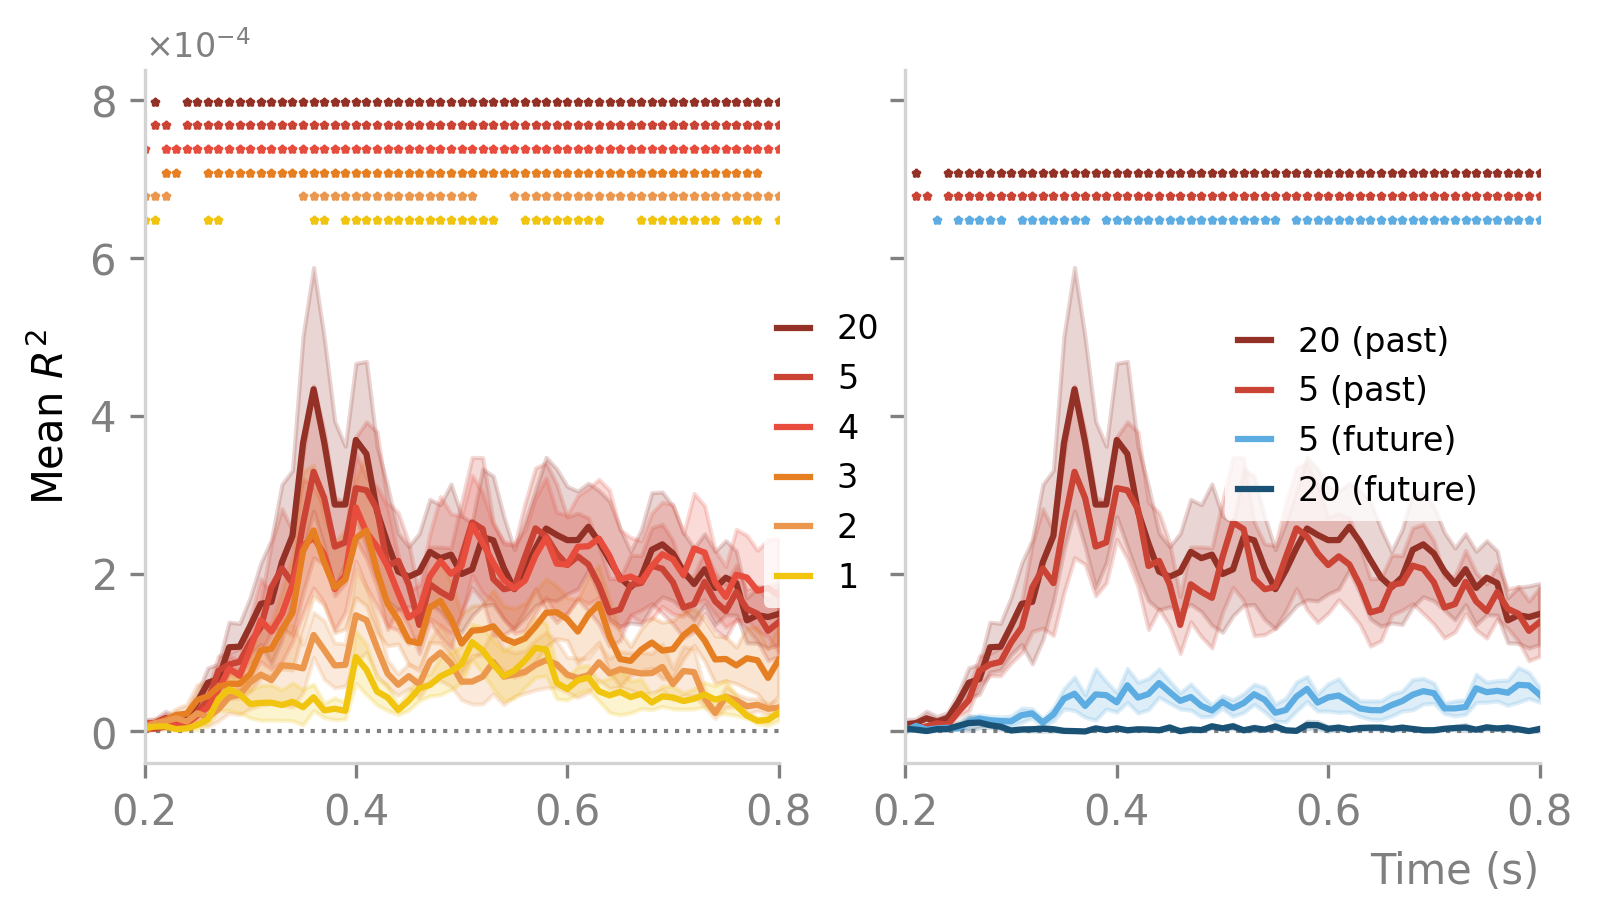

In [139]:
t = np.linspace(0.2, 0.8, ntime-20)

features = ["BERT20", "BERT5", "BERT4", "BERT3", "BERT2", "BERT1"]

s_colors = {
    "BERT20": "#943126",
    "BERT5": "#CB4335",
    "BERT4": "#E74C3C",
    "BERT3": "#E67E22",
    "BERT2": "#EB984E",
    "BERT1": "#F1C40F",
}

labels = {
    "BERT20": "20",
    "BERT5": "5",
    "BERT4": "4",
    "BERT3": "3",
    "BERT2": "2",
    "BERT1": "1",
}


fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

axs = axes[0]

sem_scale = 1
max_value = 0
min_value = 0

for name in features:
    scores = all_r2s[name]
    pvalues = all_sig[name]
    mean, sem = r2s_stats(scores, pvalues)

    if "res" in name:
        color = "#F39C12"
        label = "BERT-5 res."
    elif "lag" in name:
        color = "#3498DB"
        label = "BERT-5 lag"
    else:
        color = s_colors[name]
        label = labels[name]

    axs.plot(t, mean[20:], color=color, lw=1.5, label=label)
    axs.fill_between(t, mean[20:]-sem[20:]*sem_scale, mean[20:]+sem[20:]*sem_scale, alpha=0.2, color=color)

    if max(mean+sem*sem_scale) > max_value:
        max_value = max(mean+sem*sem_scale)

    if min(mean-sem*sem_scale) < min_value:
        min_value = min(mean-sem*sem_scale)

axs.legend(fontsize=8, edgecolor="none", handlelength=1, bbox_to_anchor=(0.95, 0.2), ncols=1)

idx = max_value + 0.00006
for name in reversed(features):
    scores = all_r2s[name]
    pvalues = all_sig[name]

    r2s_scores = r2s_corrected(scores, pvalues)
    pvalues = timewise_corrected_ttest_1samp(r2s_scores)

    onestar = np.zeros(ntime)
    onestar[20:] = (pvalues[20:] < 0.05) * idx

    if "res" in name:
        color = "#F39C12"
    elif "lag" in name:
        color = "#3498DB"
    else:
        color = s_colors[name]

    onesig = False
    for j in range(ntime-20):
        if onestar[j+20] > 0:
            axs.scatter(t[j], onestar[j+20], marker="*", s=2, color=color)
            onesig = True

    if onesig:
        idx += 0.00003
        onesig = False

#axs.vlines(0.2, min_value, max_value, linestyle='--', lw=.8, color="gray")
axs.axhline(0.0, lw=1, color="gray", linestyle=":", zorder=0)

axs.tick_params(
        axis='both',
        which='both',            
        labelsize=10,
        labelcolor="gray",
        color="gray"
    )

axs.spines[["right", "top"]].set_visible(False)

mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2,2))
axs.yaxis.set_major_formatter(mf)
axs.yaxis.get_offset_text().set_size(8)

axs.set_ylabel("Mean $R^2$", size=10)

############
features = ["BERT20", "BERT5", "BERT5-R", "BERT20-R",]

s_colors = {
    "BERT20": "#943126",
    "BERT20-R": "#1A5276",
    "BERT5": "#CB4335",
    "BERT5-R": "#5DADE2",
}

labels = {
    "BERT20": "20 (past)",
    "BERT20-R": "20 (future)",
    "BERT5": "5 (past)",
    "BERT5-R": "5 (future)",
}

axs = axes[1]

sem_scale = 1
max_value = 0
min_value = 0

for name in features:
    scores = all_r2s[name]
    pvalues = all_sig[name]
    mean, sem = r2s_stats(scores, pvalues)

    if "res" in name:
        color = "#F39C12"
        label = "BERT-5 res."
    elif "lag" in name:
        color = "#3498DB"
        label = "BERT-5 lag"
    else:
        color = s_colors[name]
        label = labels[name]

    axs.plot(t, mean[20:], color=color, lw=1.5, label=label)
    axs.fill_between(t, mean[20:]-sem[20:]*sem_scale, mean[20:]+sem[20:]*sem_scale, alpha=0.2, color=color)

    if max(mean+sem*sem_scale) > max_value:
        max_value = max(mean+sem*sem_scale)

    if min(mean-sem*sem_scale) < min_value:
        min_value = min(mean-sem*sem_scale)

axs.legend(fontsize=8, edgecolor="none", handlelength=1, bbox_to_anchor=(0.95, 0.5), ncols=1)

idx = max_value + 0.00006
for name in reversed(features):
    scores = all_r2s[name]
    pvalues = all_sig[name]

    r2s_scores = r2s_corrected(scores, pvalues)
    pvalues = timewise_corrected_ttest_1samp(r2s_scores)

    onestar = np.zeros(ntime)
    onestar[20:] = (pvalues[20:] < 0.05) * idx

    if "res" in name:
        color = "#F39C12"
    elif "lag" in name:
        color = "#3498DB"
    else:
        color = s_colors[name]

    onesig = False
    for j in range(ntime-20):
        if onestar[j+20] > 0:
            axs.scatter(t[j], onestar[j+20], marker="*", s=2, color=color)
            onesig = True

    if onesig:
        idx += 0.00003
        onesig = False

#axs.vlines(0.2, min_value, max_value, linestyle='--', lw=.8, color="gray")
axs.axhline(0.0, lw=1, color="gray", linestyle=":", zorder=0)
axs.set_xlabel("Time (s)", size=10, loc="right", color="gray")

axs.tick_params(
        axis='both',
        which='both',            
        labelsize=10,
        labelcolor="gray",
        color="gray"
    )

axs.spines[["right", "top"]].set_visible(False)


fig.savefig("../figures/r2_context_size.pdf", bbox_inches="tight")

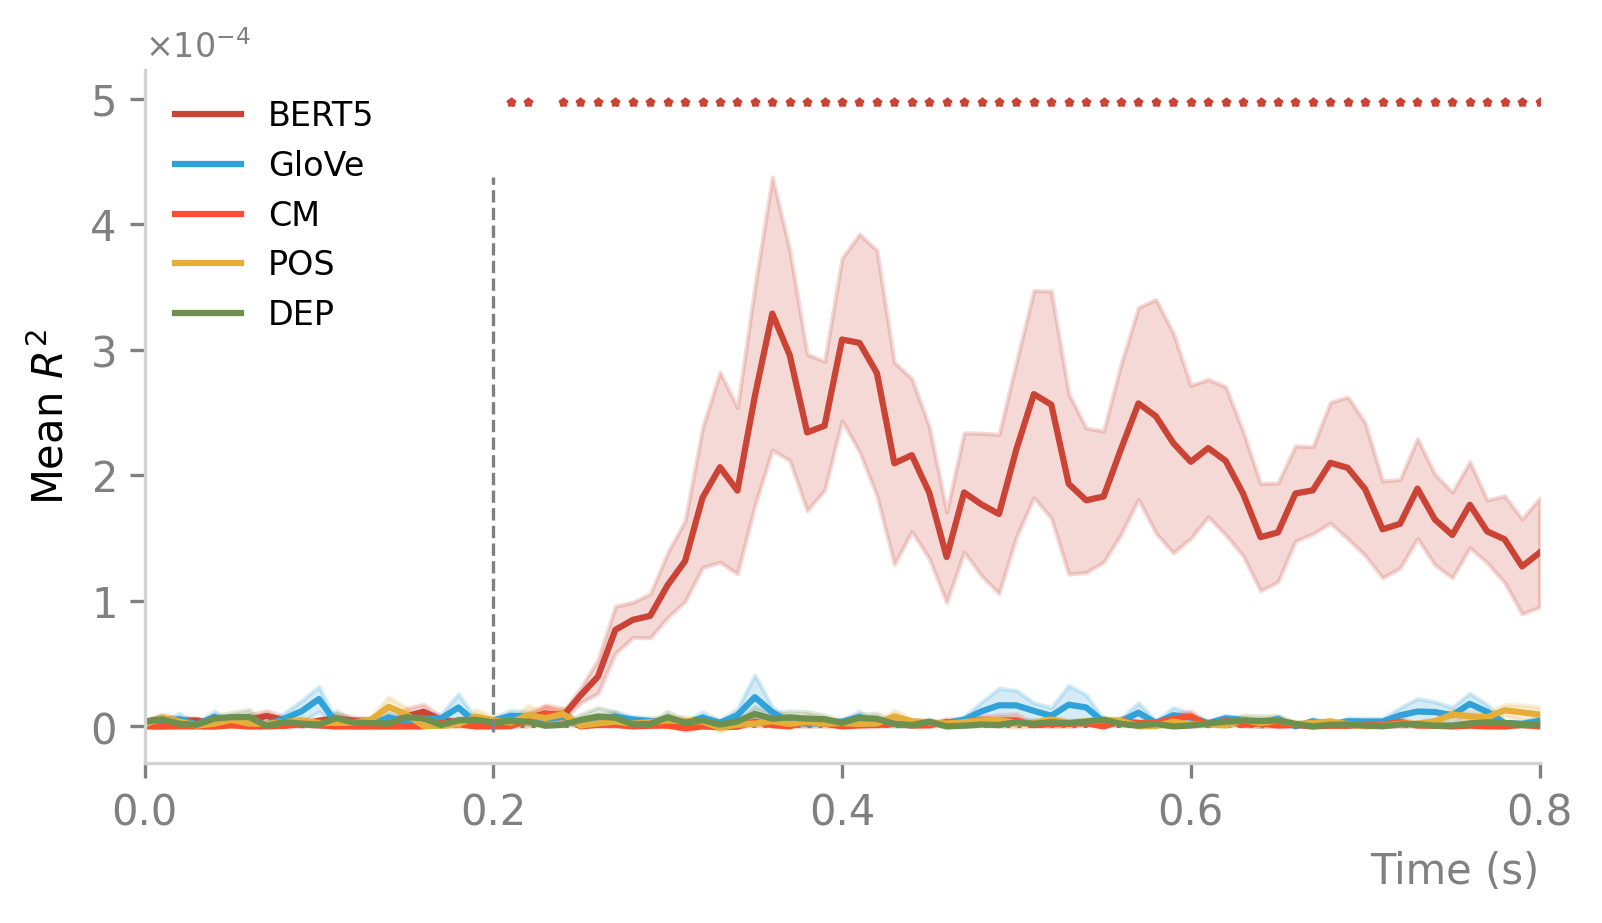

In [142]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3))
# plt.rcParams.update({'font.size': 11, 'axes.edgecolor': "lightgray"})
# plt.tick_params(which="both", colors='gray', labelsize=8)

t = np.linspace(0.0, 0.8, ntime)

axs.tick_params(
        axis='both',
        which='both',            
        labelsize=10,
        labelcolor="gray",
        color="gray"
    )


names = ["BERT5", "GloVe", "CM", "POS", "DEP"]

colors["BERT5"] = "#CB4335"

sem_scale = 1
max_value = 0
min_value = 0
for name in names:
    scores = all_r2s[name]
    pvalues = all_sig[name]
    mean, sem = r2s_stats(scores, pvalues)
    color = colors[name]
    plt.plot(t, mean, color=color, lw=1.5, label=name)
    plt.fill_between(t, mean-sem*sem_scale, mean+sem*sem_scale, alpha=0.2, color=color)
    
    if max(mean+sem*sem_scale) > max_value:
        max_value = max(mean+sem*sem_scale)
        
    if min(mean-sem*sem_scale) < min_value:
        min_value = min(mean-sem*sem_scale)

idx = max_value + 0.00006
for name in names:
    scores = all_r2s[name]
    pvalues = all_sig[name]
    
    r2s_scores = r2s_corrected(scores, pvalues)
    pvalues = timewise_corrected_ttest_1samp(r2s_scores)
    
    onestar = np.zeros(ntime)
    onestar[20:] = (pvalues[20:] < 0.05) * idx
    
    onesig = False
    for i in range(ntime):
        if onestar[i] > 0:
            plt.scatter(t[i], onestar[i], marker="*", s=2, color=colors[name])
            onesig = True
            
    if onesig:
        idx += 0.00003
        onesig = False

plt.vlines(0.2, min_value, max_value, linestyle='--', lw=.8, color="gray")
plt.axhline(0.0, lw=1, color="gray", linestyle=":", zorder=0)

axs.spines[["right", "top"]].set_visible(False)
axs.legend(fontsize=8, edgecolor="none")

mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2,2))
plt.gca().yaxis.set_major_formatter(mf)
plt.gca().yaxis.get_offset_text().set_size(8)

plt.xticks(plt.xticks()[0][::2])

plt.ylabel("Mean $R^2$", size=10)
plt.xlabel("Time (s)", size=10, loc="right", color="gray")

#plt.text(0.2, max_value, "word onset", size=8, color="gray", fontstyle="italic", ha="center")

plt.savefig("../figures/r2s_all.png", bbox_inches="tight")
plt.savefig("../figures/r2s_all.pdf", bbox_inches="tight")
plt.show()

### All correlation

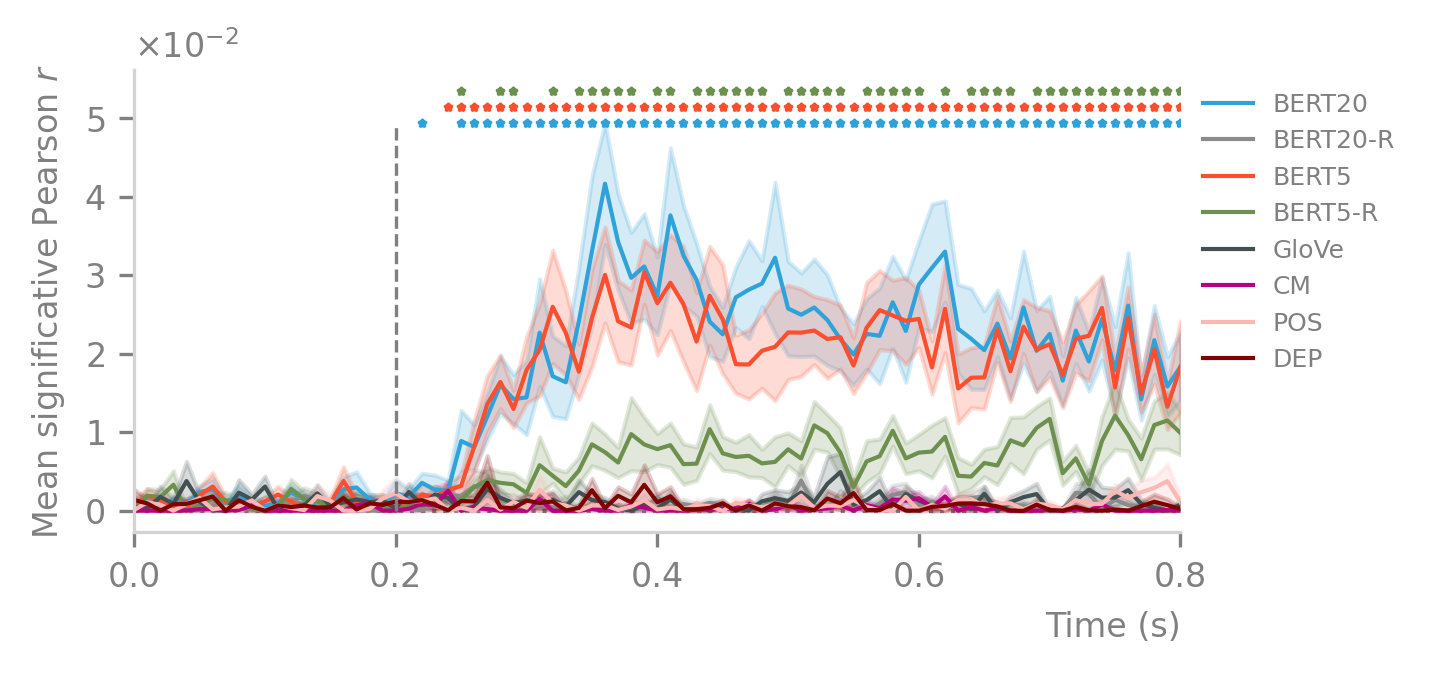

In [146]:
plt.figure(figsize=(4.5, 2))
plt.rcParams.update({'font.size': 11, 'axes.edgecolor': "lightgray"})
plt.tick_params(which="both", colors='gray', labelsize=8)

t = np.linspace(0.0, 0.8, ntime)

names = ["BERT20", "BERT20-R", "BERT5", "BERT5-R", "GloVe", "CM", "POS", "DEP"]

sem_scale = 1
max_value = 0
min_value = 0
for name in names:
    scores = all_corr[name]
    pvalues = all_sig[name]
    mean, sem = corr_stats(scores, pvalues)
    color = colors[name]
    plt.plot(t, mean, color=color, lw=1, label=name)
    plt.fill_between(t, mean-sem*sem_scale, mean+sem*sem_scale, alpha=0.2, color=color)
    
    if max(mean+sem*sem_scale) > max_value:
        max_value = max(mean+sem*sem_scale)
        
    if min(mean-sem*sem_scale) < min_value:
        min_value = min(mean-sem*sem_scale)

idx = max_value + 0.00006
for name in names:
    scores = all_corr[name]
    pvalues = all_sig[name]
    
    corr_scores = corr_corrected(scores, pvalues, corr_idx=0)
    pvalues = timewise_corrected_ttest_1samp(corr_scores)
    
    onestar = np.zeros(ntime)
    onestar[20:] = (pvalues[20:] < 0.05) * idx
    
    onesig = False
    for i in range(ntime):
        if onestar[i] > 0:
            plt.scatter(t[i], onestar[i], marker="*", s=2, color=colors[name])
            onesig = True
            
    if onesig:
        idx += 0.002
        onesig = False

plt.vlines(0.2, min_value, max_value, linestyle='--', lw=.8, color="gray")
plt.axhline(0.0, lw=1, color="gray", linestyle=":", zorder=0)

plt.gca().spines[["right", "top"]].set_visible(False)
plt.gca().legend(fontsize=6, labelcolor="gray", edgecolor="none", bbox_to_anchor=(1, 1))

mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2,2))
plt.gca().yaxis.set_major_formatter(mf)
plt.gca().yaxis.get_offset_text().set_size(8)

plt.xticks(plt.xticks()[0][::2])

plt.ylabel("Mean significative Pearson $r$", size=8, color="gray")
plt.xlabel("Time (s)", size=8, loc="right", color="gray")

#plt.text(0.2, max_value, "word onset", size=8, color="gray", fontstyle="italic", ha="center")

plt.savefig("../figures/corr_all.png", bbox_inches="tight")
plt.savefig("../figures/corr_all.pdf", bbox_inches="tight")
plt.show()

In [226]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection

def r2s_sub(scores, sig):

    means, stds = [], []

    #all_r2s = list(bert20_r2.values())
    all_sub_evoked = []
    for sub, pvalues in sig.items():
        r2s = scores[sub]
        sig = pvalues < 0.05
        all_evoked = []
        for i in range(81):
            evoked = np.zeros(208)
            sig_r2s = r2s[:, i][sig[:, i]]
            evoked[sig[:, i]] = sig_r2s
            evoked = np.mean(evoked)    
            all_evoked.append(evoked)
        all_sub_evoked.append(all_evoked)

    return np.array(all_sub_evoked)

r2s_mean_bert20 = r2s_sub(bert20_r2, bert20_sig)
r2s_mean_bertres = r2s_sub(bertres_r2, bertres_sig)
r2s_mean_pos = r2s_sub(pos_r2, pos_sig)

test_res = ttest_rel(r2s_mean_bert20, r2s_mean_bertres, alternative="greater")
test_pos_res = ttest_rel(r2s_mean_bert20, r2s_mean_pos, alternative="greater")

In [227]:
tt_test_corr = fdrcorrection(test_res[1], alpha=0.05)
tt_test_corr_pos = fdrcorrection(test_pos_res[1], alpha=0.05)

In [215]:
test_res[1] < 0.05

array([False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False,  True, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [228]:
tt_test_corr_pos

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True]),
 array([0.11867322, 0.43404239, 0.92816556, 0.11642795, 0.15234396,
        0.45222384, 0.12931454, 0.27826548, 0.51920032, 0.71551751,
        0.72649275, 0.72649275, 0.3460299 , 0.69583567, 0.8993771 ,
        0.5970946 , 0.07322011, 0.12316798, 0.10430114, 0.8993771 ,
        0.3147117 , 0.13067673, 0.3177932 , 0.27105311, 0.2984869 ,
        0.01656654,

# POS

In [7]:
#Extract all the Noun and Verb Tags
stories = np.load('../reports/pos_tags_all.npy', allow_pickle=True)
postags = np.load('../reports/pos_tags_mappings_all.npy', allow_pickle=True)
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

nouns_indices = []
verb_indices = []
cc_indices = []
adv_indices = []
adj_indices = []
for i in np.arange(stories.shape[0]):
    if get_keys_from_value(postags.item(), np.argmax(stories[i]))[0] in ['NN','NNP', 'NNS']:
        nouns_indices.append(i)
    if get_keys_from_value(postags.item(), np.argmax(stories[i]))[0] in ['VBD','VB', 'VBN', 'VBZ', 'VBG', 'VBP']:
        verb_indices.append(i)
    if get_keys_from_value(postags.item(), np.argmax(stories[i]))[0] in ['CC', 'IN']:
        cc_indices.append(i)
    if get_keys_from_value(postags.item(), np.argmax(stories[i]))[0] in ['JJ', 'JJR', 'JJS']:
        adj_indices.append(i)
    if get_keys_from_value(postags.item(), np.argmax(stories[i]))[0] in ['RBR', 'RBS', 'RB', 'WRB']:
        adv_indices.append(i)

In [21]:
pos_preds = load_results(
    exp="postag",
    kind="pred",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False,
    reshape=False
)

pos_sig = load_results(
    exp="postag",
    kind="sig_group_corrected",
    info=info,
    nchan=nchan, 
    ntime=ntime, 
    concat=False)

gt = load_test(
    exp="postag",
    info=info,
    nchan=nchan,
    ntime=ntime,
    reshape=False)

100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1266.73it/s]


In [52]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from tqdm import tqdm
from collections import defaultdict

pos_r2s = defaultdict(dict)
pos_corr = defaultdict(dict)

pos_indices = {
    "nn": nouns_indices,
    "vb": verb_indices,
    "cc": cc_indices,
    "adv": adv_indices,
    "jj": adj_indices
}

for sub, preds in tqdm(pos_preds.items()):
    for pos, idx in pos_indices.items():
        y_pred = preds[idx]
        y_test = gt[idx]
        
        pos_r2s[pos][sub] = r2_score(y_test, y_pred, multioutput="raw_values").reshape(nchan, ntime)
        
        corr = np.zeros((2, nchan*ntime))
        for i in range(nchan*ntime):
            corr[:, i] = pearsonr(y_pred[:, i], y_test[:, i])
        pos_corr[pos][sub] = corr.reshape(2, nchan, ntime)

100%|█████████████████████████████████████████████| 8/8 [00:44<00:00,  5.50s/it]


Text(1, 0, 'Time (s)')

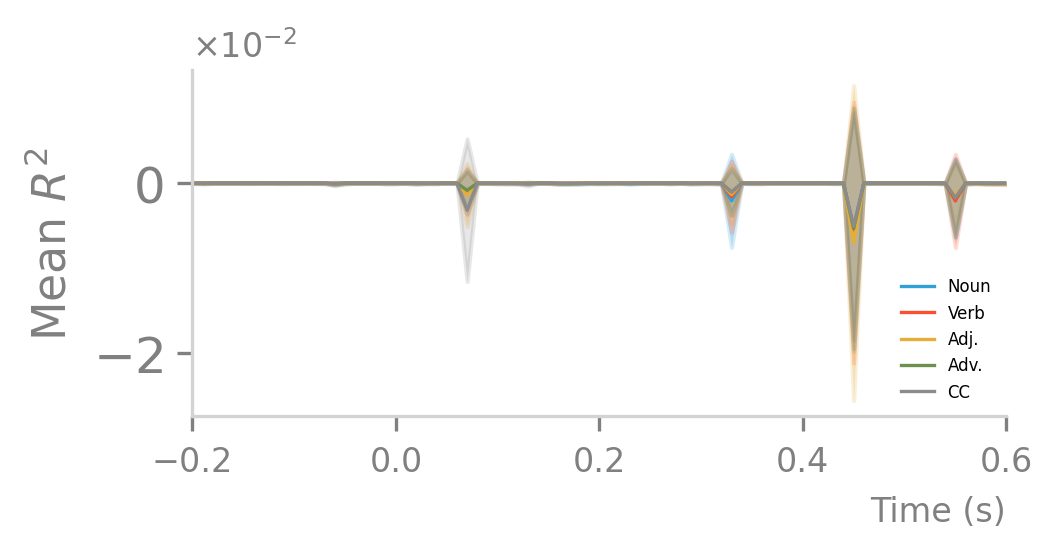

In [75]:
import matplotlib

plt.figure(figsize=(3.5, 1.5))
plt.rcParams.update({'font.size': 10, 'axes.edgecolor': "lightgray"})
plt.tick_params(which="both", colors='gray')
#plt.ylim(0.0, 3.5*1e13)
t = np.linspace(-0.2, 0.6, ntime)
names = ["Noun", "Verb", "Adj.", "Adv.", "CC"]
#colors = ["gray", "#CB4335", "#F5B7B1", "#76D7C4", "#F8C471"]
all_features = [
    (pos_r2s["nn"], pos_sig), 
    (pos_r2s["vb"], pos_sig),
    (pos_r2s["jj"], pos_sig),
    (pos_r2s["adv"], pos_sig),
    (pos_r2s["cc"], pos_sig)
]
for i, (scores, pvalues) in enumerate(all_features):
    mean, std = r2s_stats(scores, pvalues)
    color = cc.glasbey_hv[i] if names[i] != "MEG" else "gray"
    style = None if names[i] != "MEG" else ":"
    plt.plot(t, mean, color=color, linestyle=style, lw=.8, label=names[i])
    plt.fill_between(t, mean-std, mean+std, alpha=0.2, color=color)
    idx = 80
    #plt.text(idx/100 - 0.2, x[idx], names[i], color=color, size=8)
    
#plt.vlines(0.0, 0.0, 3.5e13, linestyle='--', lw=.8, color="gray")

plt.gca().spines[["right", "top"]].set_visible(False)
plt.gca().legend(fontsize=4, edgecolor="none", loc="lower right")

mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2,2))
plt.gca().yaxis.set_major_formatter(mf)
plt.gca().yaxis.get_offset_text().set_size(8)

plt.xticks(plt.xticks()[0][::1], size=8)
#plt.yticks(plt.yticks()[0], size=8)

plt.ylabel("Mean $R^2$", size=11, color="gray")
plt.xlabel("Time (s)", size=8, loc="right", color="gray")

# plt.savefig("../figures/rms-bertres-vs-bert20-5-4")
# plt.savefig("../figures/rms-bertres-vs-bert20-5-4.pdf")
#plt.text(0.0, 3.55*1e13, "word onset", size=8, color="gray", fontstyle="italic", ha="center")

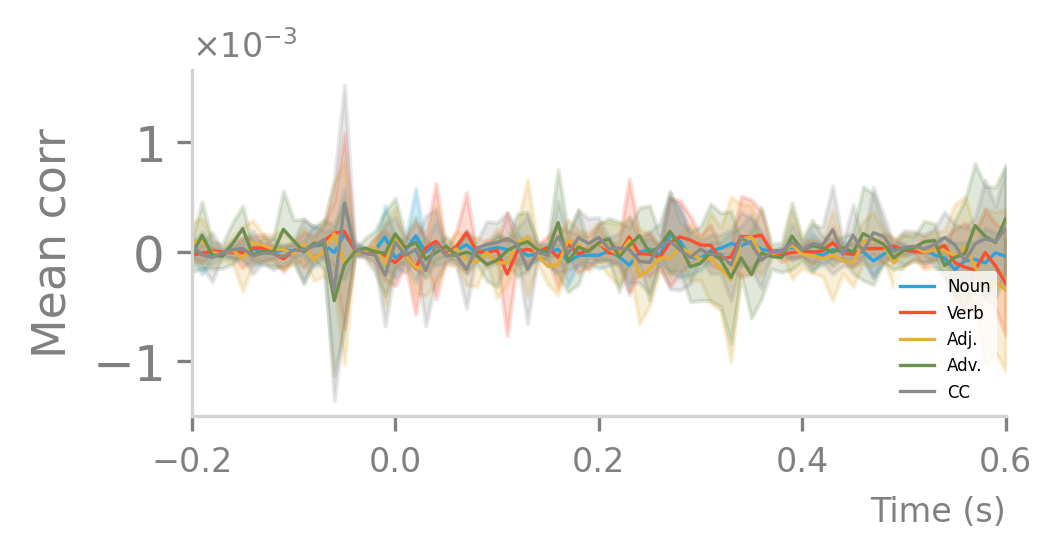

In [62]:
import matplotlib

plt.figure(figsize=(3.5, 1.5))
plt.rcParams.update({'font.size': 10, 'axes.edgecolor': "lightgray"})
plt.tick_params(which="both", colors='gray')
#plt.ylim(0.0, 3.5*1e13)
t = np.linspace(-0.2, 0.6, ntime)
names = ["Noun", "Verb", "Adj.", "Adv.", "CC"]
#colors = ["gray", "#CB4335", "#F5B7B1", "#76D7C4", "#F8C471"]
all_features = [
    (pos_corr["nn"], pos_sig), 
    (pos_corr["vb"], pos_sig),
    (pos_corr["jj"], pos_sig),
    (pos_corr["adv"], pos_sig),
    (pos_corr["cc"], pos_sig)
]
for i, (scores, pvalues) in enumerate(all_features):
    mean, std = corr_stats(scores, pvalues, corr_idx=0) # coef is from MNE
    color = cc.glasbey_hv[i] if names[i] != "MEG" else "gray"
    style = None if names[i] != "MEG" else ":"
    plt.plot(t, mean, color=color, linestyle=style, lw=.8, label=names[i])
    plt.fill_between(t, mean-std, mean+std, alpha=0.2, color=color)
    idx = 80
    #plt.text(idx/100 - 0.2, x[idx], names[i], color=color, size=8)
    
#plt.vlines(0.0, 0.0, 3.5e13, linestyle='--', lw=.8, color="gray")

plt.gca().spines[["right", "top"]].set_visible(False)
plt.gca().legend(fontsize=4, edgecolor="none", loc="lower right")

mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2,2))
plt.gca().yaxis.set_major_formatter(mf)
plt.gca().yaxis.get_offset_text().set_size(8)

plt.xticks(plt.xticks()[0][::1], size=8)
#plt.yticks(plt.yticks()[0], size=8)

plt.ylabel("Mean corr", size=11, color="gray")
plt.xlabel("Time (s)", size=8, loc="right", color="gray")

plt.savefig("../figures/rms-bertres-vs-bert20-5-4")
plt.savefig("../figures/rms-bertres-vs-bert20-5-4.pdf")
#plt.text(0.0, 3.55*1e13, "word onset", size=8, color="gray", fontstyle="italic", ha="center")